In [20]:
# This is the code associated with template banks for higher modes

# Section 1 deals with making the template banks

# Section 2 how to use the pre-made template banks to get waveforms and trigger them with strain data

# Section 3 deals with checking effectualness of the template banks

# Please email Jay (jayw@ias.edu) if there are any issues
# It would be helpful to use jupyter lab or have collapsible headings in jupyter notebook to properly view
# the different sections of the notebook

In [ ]:
# Needs the packages: sklearn, numba, multiprocess, lal, lalsimulation

In [1]:
import os, sys
sys.path.insert(0,"/Users/jayw/Dropbox/Drop_Acad/IAS/GWaves/Public_code/Template_banks") # CHANGE path
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
from numpy import amin,amax
import template_bank_generator_HM as tg
import template_bank_params_O3a_HM as tbp
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy, copy
from scipy import interpolate
from importlib import reload
import json, glob, time
import params, utils, joblib

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

import lal,lalsimulation
import multiprocess as mp

In [2]:
# Setting matplotlib params for aesthetic plots
#%matplotlib widget
%matplotlib inline
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["axes.grid"]=True;plt.rcParams["grid.alpha"]=0.4; plt.rcParams["grid.color"]='#999999'; plt.rcParams["grid.linestyle"]='--'

In [3]:
# Some of the data files relevant to this code are uploaded at
# https://drive.google.com/drive/folders/1aZBSzrYQVdNCZ0QdkSEow51km53UPLqz?usp=sharing
# Please download the files and set the data_dir path

data_dir = '/Users/jayw/Documents/Acad/GW/Public_data/'

# 1. Make template bank from scratch

In [4]:
# This section is for generating the data used to make the template bank for higher modes

In [5]:
# os.mkdir(tbp.DIR)
# os.chmod(tbp.DIR, 0o777)

In [4]:
# Initialize a random parameter dictionary to get started
par_dic = {
    'd_luminosity': 1.0,
    'f_ref': 50.0,
    'iota': 1.0,
    'l1': 0.0,
    'l2': 0.0,
    'm1': 50,
    'm2': 3.4,
    's1x': 0.000,
    's1y': 0.0,
    's1z': -0.24,
    's2x': 0.000,
    's2y': 0.0,
    's2z': -0.2,
    'phi_ref': 0.0}

def _get_s1z(chieff, q, s2z):
    return (1+q)*chieff - q*s2z

def _s1z_lim(chieff, q):
    s1z_min = np.maximum(_get_s1z(chieff, q, s2z=1), -1)
    s1z_max = np.minimum(_get_s1z(chieff, q, s2z=-1), 1)
    return s1z_min, s1z_max

def par_transform(M,lnq,chieff,cumchidiff):    
    
    _=np.zeros((len(M),6))
    
    q=np.exp(lnq)
    _[:,0]=M/(1+q); _[:,1]=M*q/(1+q)
    
    s1z_min, s1z_max = _s1z_lim(chieff, q)
    s1z = s1z_min + cumchidiff * (s1z_max - s1z_min)
    _[:,3] = ((1+q)*chieff - s1z) / q; _[:,2]=s1z
    
    return _

def inverse_transform(arr):
        """(s1z, s2z) to (chieff, cumchidiff)."""
        [m1, m2 , s1z, s2z] = arr
        q = m2 / m1
        chieff = (s1z + q*s2z) / (1 + q)
        s1z_min, s1z_max = _s1z_lim(chieff, q)
        cumchidiff = (s1z - s1z_min) / (s1z_max - s1z_min)
        return [chieff,cumchidiff]

## Define reference PSD

### Generating SVD by looking at some events from O3a (skip this)

In [ ]:
# ASD file has already been saved for O3a, so no need of running this sub-section (unless you want to remake the file)

In [16]:
# Triggerlist filenames, we'll get asdfuncs from them
fnames = [f for f in glob.glob('/data/bzackay/GW/O3Events/*/*.json')
          if ('H1' in f or 'L1' in f) and not 'GW190425' in f]

In [ ]:
n_files = min(200, len(fnames))
f_full = np.geomspace(10, 1e3, 1000)  # [Hz]
percentile = 10

import triggers_single_detector
asds = np.array([triggers_single_detector.TriggerList.from_json(fname).asdfunc(f_full)
                 for fname in np.random.choice(fnames, n_files, replace=False)])
median_asd = np.percentile(asds, percentile,  axis=0)

In [ ]:
# if not os.path.isfile(tbp.asd_filepath):
#     np.save(tbp.asd_filepath, np.c_[f_full, median_asd])
# else:
#     print(f"File {tbp.asd_filepath!r} exists, didn't overwrite.")

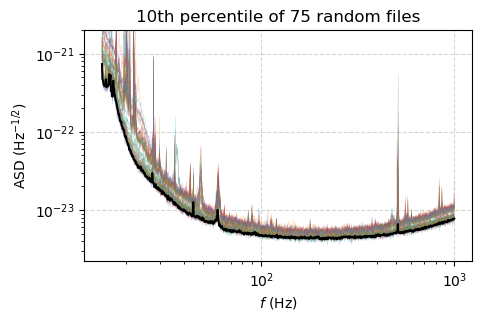

In [276]:
plt.figure(figsize=(5,3))
plt.loglog(f_full, asds.T, lw=.2, alpha=.5)
plt.loglog(f_full, median_asd, 'k', lw=1.5)
plt.title(f'{percentile}th percentile of {n_files} random files')
plt.xlabel(r'$f$ (Hz)')
plt.ylabel(r'ASD (Hz$^{-1/2}$)')
plt.ylim(top=2e-21);

### Generate freq-bins for amplitudes

In [5]:
# This does a more robust form of np.interp
tg.DEFAULT_ASDF = utils.asdf_fromfile(data_dir+'asd_o3a.npy')

In [6]:
# Measure for cosines of amplitudes

asd_data = np.load(data_dir+'asd_o3a.npy')
f_full = asd_data[0]
psd = asd_data[1]**2
df = tg.get_df(f_full)

overlap_measure = 4 * df / psd
Aref = (f_full/100)**(-7/6) # later used for normalizing the waveforms by a power law

measure = overlap_measure * (Aref**2)
cum_measure = np.cumsum(measure)
measure = measure/cum_measure[-1]
cum_measure = cum_measure/cum_measure[-1]

_ = (cum_measure>0) # Finding first element with non-zero cum_measure (for interpolation to not break)
ind = 0
for i in range(len(_)):
    if (_[i]==True): ind=i-1; break

fsInterpolate = interpolate.InterpolatedUnivariateSpline(cum_measure[ind:],f_full[ind:])

# Choose bins of frequencies with equal measure in them

f_amp = fsInterpolate(np.linspace(0.0001,1,2000)) # This gives the frequency at which the amplitudes are interpolated
Aref = (f_amp/100)**(-7/6)

psd = tg.DEFAULT_ASDF(f_amp)**2
df = tg.get_df(f_amp)
weights = 4 * df / psd * Aref**2 
weights=weights/np.sum(weights)

# Note that weights are approximately 1/2000

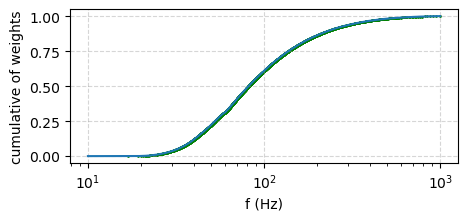

In [7]:
plt.figure(figsize=(5,2))
plt.plot(f_full,cum_measure)
plt.scatter(f_amp,np.cumsum(weights),s=1,c='g')
plt.xlabel('f (Hz)'); plt.ylabel('cumulative of weights')
plt.xscale('log')

## Generate input waveforms & split banks by amplitude

**Generate parameters**

In [8]:
# Creating samples of input parameters with appropriate priors
# Load using the following or uncomment the code below:

input_pars = np.load(data_dir+'pars_samples.npy')
Mrandom = input_pars[:,0] + input_pars[:,1]
lnqrandom = np.log(input_pars[:,1]/input_pars[:,0])
[chieffrandom , cumchidiffrandom] = inverse_transform(input_pars[:,:4].T)

# nwf=100000
# alpha=1/3

# lnqrandom=np.random.uniform(np.log(1/18),np.log(0.99),3*nwf)
# chieffrandom=np.random.uniform(-0.95,0.95,3*nwf)
# cumchidiffrandom=np.random.uniform(0,1,3*nwf)

# ## Put similar number in each bank

# Mrandom=np.random.uniform(6**(1-alpha),400**(1-alpha),nwf)
# Mrandom=Mrandom**(1/(1-alpha))

# ## Add so I have better distribution in phase scale

# _=np.random.uniform(np.log(6),np.log(400),nwf)
# _=np.exp(_)
# Mrandom=np.append(Mrandom,_)

# ## Add some more at low mchirp

# Mchrandom=np.random.uniform(2.5,30,nwf)
# _=np.exp(lnqrandom[2*nwf:])
# _=_/(1+_)**2
# _=Mchrandom/_**(3/5)
# Mrandom=np.append(Mrandom,_)

# input_pars = par_transform(Mrandom,lnqrandom,chieffrandom,cumchidiffrandom)

# Only including black holes (not neutron stars)
# mask=input_pars[:,1]>3 
# input_pars=input_pars[mask]
# Mrandom,lnqrandom,chieffrandom,cumchidiffrandom=np.c_[Mrandom,lnqrandom,chieffrandom,cumchidiffrandom][mask].T

# Deriving Mchirp
_=np.exp(lnqrandom)
_=_/(1+_)**2
Mchrandom=Mrandom*_**(3/5)

**Generate amplitudes:**

In [9]:
# This cell is used for generating the amplitudes
# not needed if you want to load the amplitudes from the cell below

def amps_HM(fs , p , hm=True):
    par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
    
    if hm is False:
        amp = np.abs(tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXAS', [(2, 2)])[0])
        
    else:
        amp = np.zeros((3,len(fs)))
        amp[0] = np.abs(tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXAS', [(2, 2)])[0])
        amp[1] = np.abs(tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXHM', [(3, 3)])[0])
        amp[2] = np.abs(tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXHM', [(4, 4)])[0])
        # can use Phenom HM if XHM doesn't work
        
    return(amp)

In [ ]:
# Better generate the amplitude samples from the code below and then save them for easy access in the future
# amps_samples = np.load(...)

## Code to generate the above samples (takes about 4 hours)
with mp.Pool(10) as p:
        amps_samples = np.abs(p.starmap(amps_HM,
                           ((f_amp, pars) for pars in input_pars)))

# Normalizing the amplitudes by f^{-7/6} using the following code

amps_samples /= Aref
_ = np.sum(weights*amps_samples**2,axis=-1)**0.5
for i in range(len(amps_samples)):
    amps_samples[i] = (amps_samples[i].T/_[i]).T

In [10]:
#%%time

nbanks=17

# Splitting the banks using K-Means clustering algorithm on amplitudes of samples
# either run the kmeans again or load it

import pickle

with open(data_dir+'kmeans.pkl', 'rb') as f:
    kmeans = pickle.load(f)

# kmeans = KMeans(n_clusters=nbanks, random_state=0).fit(amps_samples[:,0][::2]) # Time intensive
# pickle.dump(kmeans, open(os.path.join(tbp.wf_DIR,'kmeans.pkl'), 'wb')) # saving

/Users/jayw/miniconda3/envs/gw/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.1.2 when using version 1.4.dev0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
Af_kmeans_22 = np.asarray([x/np.sum(x**2*weights)**0.5 for x in kmeans.cluster_centers_])
Af_kmeans_cumsum = np.cumsum(Af_kmeans_22**2*weights,axis=1)
order = np.argsort(np.argmin((Af_kmeans_cumsum-0.97)**2,axis=1))[::-1] # Ordered by cumulative of 22 mean amplitude
Af_kmeans_22 = Af_kmeans_22[order]

In [12]:
bank_ids = np.load(data_dir + 'bank_ids.npy')

# bank_ids = kmeans.predict(amps_samples[:,0])
# bank_ids = np.asarray([np.where(order == b)[0][0] for b in bank_ids])
# np.save(os.path.join(tbp.wf_DIR,'bank_ids.npy'), bank_ids)

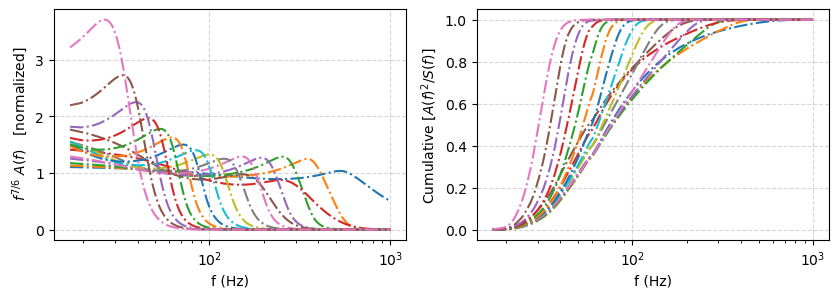

In [13]:
plt.figure(figsize=(10,3))

plt.subplot(121)
for Af in Af_kmeans_22:
    plt.plot(f_amp,Af,'-.')
plt.xlabel('f (Hz)'); plt.ylabel(' $f^{7/6}\ A(f) $   [normalized]')
plt.xscale('log')

Af_kmeans_cumsum=np.cumsum(Af_kmeans_22**2*weights,axis=1)
plt.subplot(122)
for Af in Af_kmeans_cumsum:
    plt.plot(f_amp,Af,'-.')
plt.xlabel('f (Hz)'); plt.ylabel('Cumulative [$ A(f)^2/S(f) $]')
plt.xscale('log')

In [15]:
cosines_kmeans_max=np.einsum('ij,kj,j', Af_kmeans_22, amps_samples[:,0],weights)
cosines_kmeans_max=np.max(cosines_kmeans_max,axis=0)

NameError: name 'amps_samples' is not defined

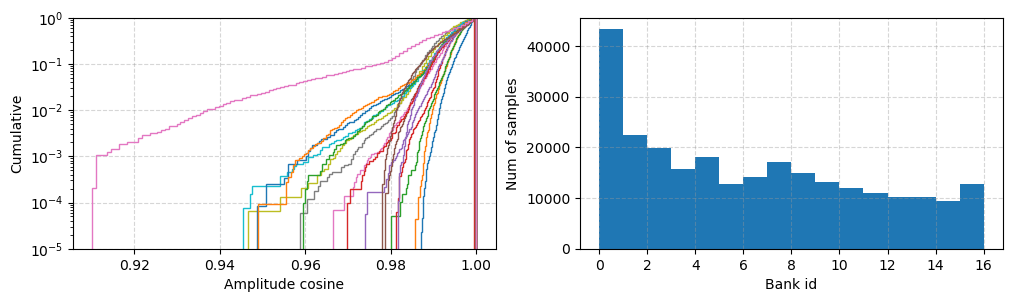

In [15]:
# Cosines for waveform amplitudes with Af_kmeans for the 22 mode

plt.figure(figsize=(12,3))
plt.subplot(121)
for ib in range(nbanks):
    plt.hist(cosines_kmeans_max[bank_ids==ib],bins=100,histtype='step',density=True, cumulative=True);
plt.yscale('log'); plt.xlabel('Amplitude cosine'); plt.ylabel('Cumulative'); plt.ylim(bottom=1e-5);

plt.subplot(122)
plt.hist(bank_ids,bins=np.linspace(0,16,17));
plt.xlabel('Bank id'); plt.ylabel('Num of samples');

# There is a correction for Bank 16 amplitudes based on SVDs and random forest which will be introduced later

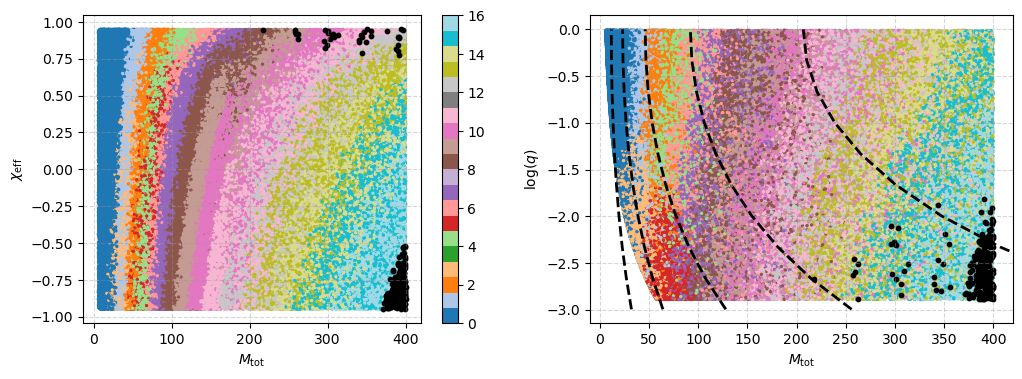

In [16]:
# Colors represent various banks, black dashed are lines of constant chirp mass, black dots are points with cos<0.96

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(Mrandom,chieffrandom,c=bank_ids,s=2,cmap='tab20'); plt.colorbar()
bad=cosines_kmeans_max < 0.96
plt.scatter(Mrandom[bad],chieffrandom[bad],s=10,c='k');
plt.xlabel('$M_\mathrm{tot}$'); plt.ylabel('$\chi_\mathrm{eff}$')
plt.subplot(122)
plt.scatter(Mrandom,lnqrandom,c=bank_ids,s=2,cmap='tab20');
plt.scatter(Mrandom[bad],lnqrandom[bad],c='k',s=10)
plt.xlabel('$M_\mathrm{tot}$'); plt.ylabel('log($q$)')

# Overplotting constant chirp mass contours for dividing banks from Roulet et al. 19
lnq=np.linspace(np.log(0.05),0,10)
q=np.exp(lnq)
eta=q/(1+q)**2
plt.plot((5/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((10/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((20/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((40/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.plot((90/eta**(3/5)),lnq,'--',c='k',lw=2)
plt.xlim(-10,420);

In [175]:
# Generating mean amplitudes for higher modes

Af_kmeans_33 = Af_kmeans_22.copy(); Af_kmeans_44 = Af_kmeans_22.copy()

for i in range(len(Af_kmeans_22)):
    mask = bank_ids==i
    Af_kmeans_33[i] = np.mean(amps_samples[:,1,:][mask] , axis=0)
    Af_kmeans_33[i] /= np.sum(Af_kmeans_33[i]**2*weights)**0.5
    
    Af_kmeans_44[i] = np.mean(amps_samples[:,2,:][mask] , axis=0)
    Af_kmeans_44[i] /= np.sum(Af_kmeans_44[i]**2*weights)**0.5

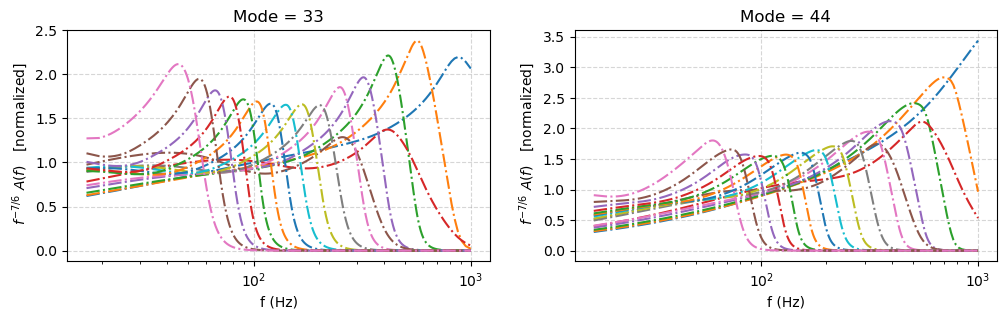

In [21]:
plt.figure(figsize=(12,3))

plt.subplot(121)
for Af in Af_kmeans_33:
    plt.plot(f_amp,Af,'-.')
plt.xlabel('f (Hz)'); plt.ylabel(' $f^{-7/6}\ A(f) $   [normalized]')
plt.xscale('log'); plt.title('Mode = 33')

plt.subplot(122)
for Af in Af_kmeans_44:
    plt.plot(f_amp,Af,'-.')
plt.xlabel('f (Hz)'); plt.ylabel(' $f^{-7/6}\ A(f) $   [normalized]')
plt.xscale('log'); plt.title('Mode = 44');

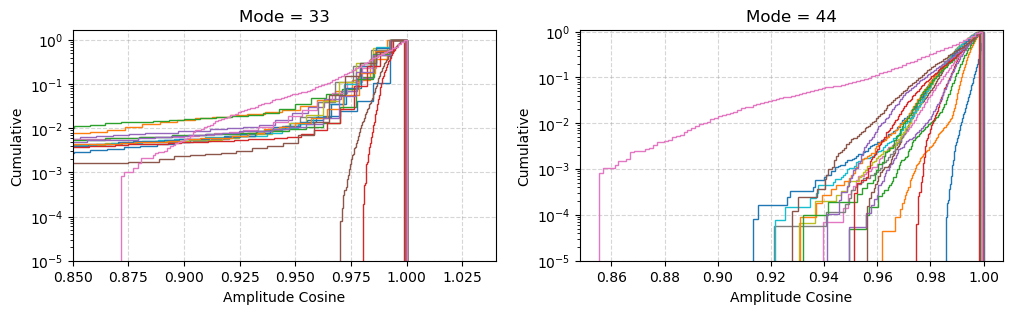

In [22]:
# Cosines for waveform amplitudes with Af_kmeans for the higher modes

# cosines_kmeans_max=np.array([])
# for i in range(nbanks):
#     cosines_kmeans_max=np.append(cosines_kmeans_max,(np.sum(Af_kmeans_33[i]*amps_samples[:,1][bank_ids==i]*weights, axis=1)))

plt.figure(figsize=(12,3))
plt.subplot(121)
for i in range(nbanks):
    plt.hist(np.sum(Af_kmeans_33[i]*amps_samples[:,1][bank_ids==i]*weights, axis=-1),bins=100,histtype='step', density=True, cumulative=True);
plt.yscale('log'); plt.xlabel('Amplitude Cosine'); plt.ylabel('Cumulative'); plt.title('Mode = 33'); plt.ylim(bottom=1e-5);plt.xlim(left=0.85)

# cosines_kmeans_max=np.array([])
# for i in range(nbanks):
#     cosines_kmeans_max=np.append(cosines_kmeans_max,())

plt.subplot(122)
for i in range(nbanks):
    plt.hist(np.sum(Af_kmeans_44[i]*amps_samples[:,2][bank_ids==i]*weights, axis=-1),bins=100,histtype='step', density=True, cumulative=True);
plt.yscale('log'); plt.xlabel('Amplitude Cosine'); plt.ylabel('Cumulative'); plt.title('Mode = 44'); plt.ylim(bottom=1e-5);

In [177]:
del amps_samples # saving memory, as this is not needed in the next section

## SVD for phases

In [21]:
def gram_schmidt_columns(X,measure):
    ws=measure**0.5
    Q, R = np.linalg.qr((X*ws).T)
    return Q.T/ws

def project_out(v,basis,measure):
    #return v - (basis @ (v*measure)) @ basis
    return v - ((v*measure) @ basis.T) @ basis

In [22]:
## Choose a different set of frequency bins for each bank

n_fs_basis = 1000 # Number of frequency bins for phase
# weights_bank = np.ones(1000)/1000 

f_phases_banks = []
f_unwrap_banks = []
basis_banks = []
weights_banks = [] # Note this is square of wts used in template_bank_generator_hm.py

for ib in range(nbanks):
    Af_bank=Af_kmeans_22[ib]
    Af_bank_interp=interpolate.InterpolatedUnivariateSpline(f_amp , Af_bank*Aref)

    mask = f_full > f_amp[0]
    fs_fine = f_full[mask]
    df = tg.get_df(fs_fine)
    psd = tg.DEFAULT_ASDF(fs_fine)**2
    measure_bank = 4 * df / psd * Af_bank_interp(fs_fine)**2
    measure_bank = measure_bank/np.sum(measure_bank)

    cum_measure_bank = np.cumsum(measure_bank)
    
    _ = (cum_measure_bank>1e-6) # Finding first element with non-zero cum_measure
    ind0=0; ind1=len(cum_measure_bank)
    for i in range(len(_)):
        if (_[i]==True and i>0): ind0=i-1; break
        
    _=(cum_measure_bank>1-1e-6) # Finding elements before cum_measure = 1
    for i in range(len(_)):
        if (_[i]==True and i<len(cum_measure_bank)): ind1=i+1; break
    fsInterpolate = interpolate.InterpolatedUnivariateSpline(cum_measure_bank[ind0:ind1],fs_fine[ind0:ind1])

    ## Choose subset of frequencies
    if ib==0: f_phase=fsInterpolate(np.linspace(0.01,0.995,n_fs_basis)) # in order to reduce the number of templates in bank 0
    else: f_phase=fsInterpolate(np.linspace(0.001,0.999,n_fs_basis))

    ## Save frequencies for unwrap
    fmax=f_phase[-1]
    fmin=f_phase[0]
    fmid=np.exp(0.5*(np.log(fmax)+np.log(fmin)))
    mchirp_ib = Mchrandom[bank_ids==ib]
    mchirp_min=np.min([np.min(mchirp_ib),20.])
    
    psd = tg.DEFAULT_ASDF(f_phase)**2
    df = tg.get_df(f_phase)
    weights_bank = 4 * df / psd * Af_bank_interp(f_phase)**2
    weights_bank /= np.sum(weights_bank) # these values should be close to 1e-3

    f_unwrap_bank = tg.get_efficient_frequencies(fmin=fmin, fmid=fmid, fmax=fmax,
                              mchirp_min=mchirp_min ,delta_radians=0.5)

    vs_bank = np.asarray([np.ones(len(f_phase)),f_phase])
    basis_bank = gram_schmidt_columns(vs_bank, weights_bank)
    
    f_phases_banks.append(f_phase)
    f_unwrap_banks.append(f_unwrap_bank)
    basis_banks.append(basis_bank)
    weights_banks.append(weights_bank)

In [23]:
# For saving a part of Multibank data

# for i in range(nbanks):
#     ## os.makedirs(os.path.join(tbp.DIR,'BBH_'+str(i))) # To create the directories
#     np.save(os.path.join(tbp.DIR,'BBH_'+str(i),'Af.npy'),np.c_[f_amp,Af_kmeans_22[i]*Aref,Af_kmeans_33[i]*Aref,Af_kmeans_44[i]*Aref])
#     np.save(os.path.join(tbp.DIR,'asd.npy'), np.load(tbp.asd_filepath))
    
#     np.save(os.path.join(tbp.DIR,'BBH_'+str(i),'f_phases.npy'),f_phases_banks[i])
#     np.save(os.path.join(tbp.DIR,'BBH_'+str(i),'f_unwrap_phases.npy'),f_unwrap_banks[i])
#     np.save(os.path.join(tbp.DIR,'BBH_'+str(i),'weights_phases.npy'),np.sqrt(weights_banks[i])) # Note the sqrt

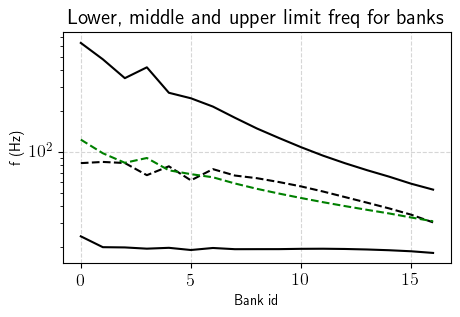

In [24]:
qaz=np.asarray(f_phases_banks)
plt.plot(range(len(Af_kmeans_22)),qaz[:,0],c='k')
plt.plot(range(len(Af_kmeans_22)),qaz[:,-1],c='k')
fmid=np.exp(np.mean(np.log(qaz),axis=1))
plt.plot(range(len(Af_kmeans_22)),fmid,'--',c='k')
fmid=np.exp(0.5*(np.log(qaz[:,0])+np.log(qaz[:,-1])))
plt.plot(range(len(Af_kmeans_22)),fmid,'--',c='g')

plt.yscale('log'); plt.xlabel('Bank id'); plt.ylabel('f (Hz)')
plt.title('Lower, middle and upper limit freq for banks');

In [25]:
# Either directly load the 22 phases or generate them with the commented out code

phases_samples = np.load(os.path.join(tbp.wf_DIR,'phases_samples.npy'))

# def gen_phases(i):
#     bank_id=bank_ids[i]; p=input_pars[i]
#     par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
#     phases = tg.compute_hplus_hcross(f_unwrap_banks[bank_id], par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
#     phases = np.unwrap(np.angle(phases))
    
#     phases = np.interp(f_phases_banks[bank_id],f_unwrap_banks[bank_id],phases)
#     phases = project_out(phases,basis_banks[bank_id],weights_banks[bank_id])
#     return(phases)

# with mp.Pool(22) as p:
#         phases_samples = p.map(gen_phases,np.arange(len(bank_ids)))
# phases_samples = np.asarray(phases_samples)

# np.save(os.path.join(tbp.wf_DIR,'phases_samples.npy'),phases_samples)

## Making Sub-banks

In [26]:
# Number determined by waveform support in time-domain space
# see the code at the end of this section 'Source code for determining number of sub-bank splits'
SubBankSplits=[5,3,3,3,3,3,3,2,2,1,1,1,1,1,1,1,1]

# For copying this to metadata
# _ = ['BBH_'+str(i) for i in range(nbanks)]
# _dic = dict(zip(_ , SubBankSplits))

In [27]:
## Assign samples to bins in scale within each bank

subbank_ids = np.zeros(len(bank_ids),dtype=int)
SubBank_Mchirp_bins=[]
for ib in range(nbanks):
    mask= (bank_ids==ib)
    mchirp_bank = Mchrandom[mask]
    nbins = SubBankSplits[ib]
    bn = np.quantile(mchirp_bank,np.linspace(0,1,nbins+1))
    bins = list(zip(bn[:-1],bn[1:]))
    print('Bank ... ',ib,' num subbanks:  ', len(bins))
    print(r'M_chirp ranges=',np.round(bn,1))
    subbank_id=np.zeros(len(mchirp_bank),dtype=int)
    for isb in range(len(bins)):
        mask2 = (mchirp_bank>(bins[isb][0])); mask2 *= (mchirp_bank<=(bins[isb][1]));
        subbank_id[mask2]=isb
    subbank_ids[mask]=subbank_id
    SubBank_Mchirp_bins.append(bins)
# np.save(os.path.join(tbp.wf_DIR,'SubBank_Mchirp_bins.npy'),SubBank_Mchirp_bins) # Uncomment to save the bins

Bank ...  0  num subbanks:   5
M_chirp ranges= [ 2.6  5.4  7.   8.8 11.  19.6]
Bank ...  1  num subbanks:   3
M_chirp ranges= [ 8.  14.9 18.4 30.2]
Bank ...  2  num subbanks:   3
M_chirp ranges= [10.4 20.2 24.6 41.3]
Bank ...  3  num subbanks:   3
M_chirp ranges= [ 5.3  9.4 11.8 16.7]
Bank ...  4  num subbanks:   3
M_chirp ranges= [12.5 22.6 28.  52.2]
Bank ...  5  num subbanks:   3
M_chirp ranges= [ 8.  13.1 16.1 22.2]
Bank ...  6  num subbanks:   3
M_chirp ranges= [17.4 26.4 35.3 67.8]
Bank ...  7  num subbanks:   2
M_chirp ranges= [11.8 27.2 81. ]
Bank ...  8  num subbanks:   2
M_chirp ranges= [ 13.7  35.2 100.8]
Bank ...  9  num subbanks:   1
M_chirp ranges= [ 16.7 116.4]
Bank ...  10  num subbanks:   1
M_chirp ranges= [ 19.4 138.1]
Bank ...  11  num subbanks:   1
M_chirp ranges= [ 23.2 161.3]
Bank ...  12  num subbanks:   1
M_chirp ranges= [ 27.  173.5]
Bank ...  13  num subbanks:   1
M_chirp ranges= [ 32.5 173.8]
Bank ...  14  num subbanks:   1
M_chirp ranges= [ 35.6 173.6]
Bank 

In [28]:
SVD_SubBanks=[]
for ib in range(nbanks):
    wts=weights_banks[ib]**0.5
    bins=SubBank_Mchirp_bins[ib]
    _=[]
    for isb in range(len(bins)):
        mask=bank_ids==ib; mask*=subbank_ids==isb
        phases=phases_samples[mask]
        if (isb==0): print('Bank ',ib, ': # of samples in each sub-bank', len(phases))
        scaled_phases=phases*wts
        mean_phases=np.mean(scaled_phases,axis=0)
        Up, sp, Vph = np.linalg.svd(scaled_phases-mean_phases, full_matrices=False)
        _.append([Up, sp, Vph, mean_phases])

    SVD_SubBanks.append(_)

Bank  0 : # of samples in each sub-bank 8694
Bank  1 : # of samples in each sub-bank 7488
Bank  2 : # of samples in each sub-bank 6609
Bank  3 : # of samples in each sub-bank 5223
Bank  4 : # of samples in each sub-bank 6041
Bank  5 : # of samples in each sub-bank 4236
Bank  6 : # of samples in each sub-bank 4729
Bank  7 : # of samples in each sub-bank 8597
Bank  8 : # of samples in each sub-bank 7448
Bank  9 : # of samples in each sub-bank 13159
Bank  10 : # of samples in each sub-bank 12014
Bank  11 : # of samples in each sub-bank 10953
Bank  12 : # of samples in each sub-bank 10309
Bank  13 : # of samples in each sub-bank 10191
Bank  14 : # of samples in each sub-bank 9364
Bank  15 : # of samples in each sub-bank 8099
Bank  16 : # of samples in each sub-bank 4787


In [29]:
# Checking performance of three cases: 2D calpha grid, 3D calpha grid, 2D + random forest
# for a particular subbank (ib,isb)

ib = 0 # ib is index of bank

rg_rf = RandomForestRegressor(n_estimators=60, max_depth=60, random_state=2)

wt=weights_banks[ib]**0.5
bins=SubBank_Mchirp_bins[ib]
SVD_SubBank=SVD_SubBanks[ib]
cos_exp_f0=[]
cos_exp_f1=[]
cos_exp_f2=[]

for isb in range(len(bins)): # isb is index of subbank
    Up, sp, Vph, mean_phase = SVD_SubBank[isb]
    phases = Up @ np.diag(sp) @ Vph + mean_phase
    ca = Up @ np.diag(sp)
    
    #1
    ca2=ca.copy()
    ca2[:,2:]=0
    ca2=np.rint(ca2*8)/8. # Gridding
    phases_f= ca2 @ Vph + mean_phase
    cos_exp_f0.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases/wt)*wt))))
    
    #2
    ca2=ca.copy()
    ca2[:,3:]=0
    ca2=np.rint(ca2*8)/8. # Gridding
    phases_f= ca2 @ Vph + mean_phase
    cos_exp_f1.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases/wt)*wt))))
    
    #3
    ndims=2
    # if ((ib==0 and isb==2) and (ib==2 and isb==0)): ndims=3
    # (earlier we used ndims=3 for a few cases but now no longer needed)
    ca2=ca.copy(); ca2=np.rint(ca2*8)/8.; ca2[:,ndims:]=0
    
    # Training a RF:
    ind=np.random.choice([0, 1], size=(len(ca),), p=[1./2, 1./2]).astype('bool');
    ca2=ca2[ind]; phases=phases[ind]
    rg_rf.fit(ca[:, :ndims][~ind],ca[:,ndims:10][~ind])
    
    # or directly loading the RF:
    # rg_rf = pickle.load(open(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'RandomForest.pkl'), "rb"))
    
    ca2[:,ndims:10]=rg_rf.predict(ca2[:,:ndims])
    phases_f= ca2 @ Vph + mean_phase
    cos_exp_f2.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases/wt)*wt))))

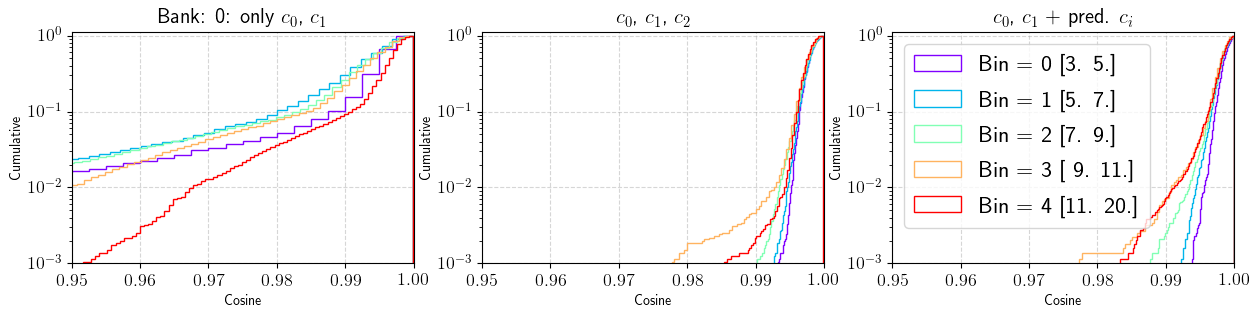

In [30]:
from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, len(bins)))
plt.figure(figsize=(15,3))

plt.subplot(131)
for isb in range(len(bins)):
    _=plt.hist(cos_exp_f0[isb],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb])
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.95,1)
plt.xlabel('Cosine'); plt.ylabel('Cumulative')
plt.title('Bank: '+str(ib)+': only $c_0$, $c_1$');

plt.subplot(132)
for isb in range(len(bins)):
    _=plt.hist(cos_exp_f1[isb],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb])
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.95,1)
plt.xlabel('Cosine'); plt.ylabel('Cumulative')
plt.title('$c_0$, $c_1$, $c_2$');

plt.subplot(133)
for isb in range(len(bins)):
    _=plt.hist(cos_exp_f2[isb],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb])
    
plt.yscale('log')
plt.legend(loc=2) #loc=(1.05,0)
plt.ylim(0.001,1.1); plt.xlim(0.95,1)
plt.xlabel('Cosine'); plt.ylabel('Cumulative')
plt.title('$c_0$, $c_1$ + pred. $c_i$');

In [53]:
# Saving the SVDs and the random forest (and everything else corresponding to the sub-banks)

rg_rf = RandomForestRegressor(n_estimators=60, max_depth=60, random_state=2)
for ib in range(nbanks):
    SVD_SubBank=SVD_SubBanks[ib]
    
    for isb in range(SubBankSplits[ib]):
        dire2 = os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb))
#         ### os.makedirs(dire2); metadata={} # initializing the directories
        # Up, sp, Vph, mean_phase=SVD_SubBank[isb]
        # ca = Up @ np.diag(sp)
        # np.save(os.path.join(dire2,'avg_phase_evolution.npy'),mean_phase)
        # np.save(os.path.join(dire2,'svd_phase_basis.npy'),Vph[:10])
        # np.save(os.path.join(dire2,'coeffs.npy'),ca[:,:10])
        # np.save(os.path.join(dire2,'params.npy'), input_pars[(bank_ids==ib) * (subbank_ids==isb)])
        
#           ########## Saving the metadata files ##############
#         with open(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'), 'r') as f:
#             metadata = json.load(f)
#             metadata['ndims']=ndims; metadata['approximant']='IMRPhenomXHM'; metadata['modes']=['22','33','44']
#         with open(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'), 'w') as f:
#             json.dump(metadata, f, indent=2, cls=utils.NumpyEncoder)
#           ##################################################

        # rg_rf.fit(ca[:, :ndims],ca[:,ndims:10]) # Time intensive
        # joblib.dump(rg_rf, os.path.join(dire2,'RandomForest.pkl'), compress=3)

### Higher mode SVDs

In [19]:
# Phase difference arrays for HM (e.g. 1/3 Psi_33(3f) - 1/2 Psi22(2f))

# Either directly load the phases or generate them with the commented out code below

phases_samples = np.load(os.path.join(tbp.wf_DIR, 'phases_samples_33_44.npy'))

In [20]:
# Generating the phases using PhenomXHM

# def gen_phases(i):
#     bank_id=bank_ids[i]; p=input_pars[i]
#     par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
#     phases22 = tg.compute_hplus_hcross(f_unwrap_banks[bank_id], par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
#     phases22 = np.unwrap(np.angle(phases22))
    
#     phases33 = tg.compute_hplus_hcross(f_unwrap_banks[bank_id]*3/2, par_dic, 'IMRPhenomXHM', [(3, 3)])[0]
#     phases33 = np.unwrap(np.angle(phases33))
#     phases33 = np.interp(f_phases_banks[bank_id],f_unwrap_banks[bank_id], phases33/3-phases22/2) * 3
    
#     phases44 = tg.compute_hplus_hcross(f_unwrap_banks[bank_id]*4/2, par_dic, 'IMRPhenomXHM', [(4, 4)])[0]
#     phases44 = np.unwrap(np.angle(phases44))
#     phases44 = np.interp(f_phases_banks[bank_id],f_unwrap_banks[bank_id], phases44/4-phases22/2) * 4
#     return(np.c_[phases33,phases44].T)

################################################
# Generating the phases from the above function using multiprocessing

# with mp.Pool(20) as p:
#         phases_samples = p.map(gen_phases, np.arange(len(bank_ids)))
        
# phases_samples = np.asarray(phases_samples)
# np.save(os.path.join(tbp.wf_DIR,f'phases_samples_33_44.npy'),phases_samples)

In [21]:
def SVD_HM_banks(ib): #range(nbanks)
    wts=weights_banks[ib]**0.5
    bins=SubBank_Mchirp_bins[ib]
    ca_SubBanks=[]; Vph_SubBanks=[]; phases_SubBanks=[]
    for isb in range(len(bins)):
        wts=weights_banks[ib]**0.5
        mask=bank_ids==ib; mask*=subbank_ids==isb
        phases = phases_samples[mask]
        constant = np.sum(phases*weights_banks[ib],axis=-1)
        phases = (phases.T - constant.T).T
        constant[:,0] = constant[:,0] % (np.pi) # phi_ref can absorb the change of 33 phase by pi
        constant[:,1] = constant[:,1] % (2*np.pi)
          
        phases *= wts
        mean_phases = np.mean(phases, axis=0)
        phases -= mean_phases
        Up, sp, Vph = np.linalg.svd(phases[:,0,:], full_matrices=False)
        ca33 = (Up @ np.diag(sp))[:,:ndims_HM]; Vph33 = Vph[:ndims_HM]
        
        Up, sp, Vph = np.linalg.svd(phases[:,1,:], full_matrices=False)
        ca44 = (Up @ np.diag(sp))[:,:ndims_HM]; Vph44 = Vph[:ndims_HM]
        
        ca_SubBanks.append(np.c_[constant, ca33, ca44]);
        Vph_SubBanks.append(np.r_[mean_phases, Vph33, Vph44]);
        phases_SubBanks.append(phases+mean_phases)
    return(ca_SubBanks, Vph_SubBanks, phases_SubBanks)

In [27]:
# Checking the cosines

ib = 8 # id of bank to probe
ndims_HM = 3 # Dimensions of HM phase basis to include
ndims=2 # Number of dimensions used for calpha_22

rg_rf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=2)

wt=weights_banks[ib]**0.5
bins=SubBank_Mchirp_bins[ib]
ca_SubBanks, Vph_SubBanks, phases_SubBanks = SVD_HM_banks(ib)
cos_exp_f0=[]; cos_exp_f1=[]; cos_exp_f2=[]

# Loading 22 calphas
dire = os.path.join(tbp.DIR,'BBH_'+str(ib))

for isb in range(len(bins)):
    
    dire2 = os.path.join(dire,'bank_'+str(isb))
    ca22 = np.load(os.path.join(dire2,'coeffs.npy'))[:,:ndims]#[~mask_outliers]
    
    ca  = ca_SubBanks[isb]; Vph = Vph_SubBanks[isb]; phases = phases_SubBanks[isb]
    
    # Training a RF:
    ind=np.random.choice([0, 1], size=(len(ca),), p=[1./2, 1./2]).astype('bool'); 
    rg_rf.fit(ca22[~ind],ca[~ind])
    ca22_grid = np.rint(ca22*8)/8.;
    ca_grid_pred = rg_rf.predict(ca22_grid[ind])
    
    constant = ca[:,:2]; ca = ca[:,2:]; 
    mean_phase = Vph[:2,:]; Vph = Vph[2:,:]

    for mode in range(2):
        ca_grid=np.zeros_like(ca[:,mode*ndims_HM:(mode+1)*ndims_HM])
        phases_f = ca_grid @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:] + mean_phase[mode]
        cos_exp_f0.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases[:,mode,:]/wt)*wt))))

        ca_grid=ca[:,mode*ndims_HM:(mode+1)*ndims_HM].copy()
        ca_grid=np.rint(ca_grid*8)/8. # Gridding
        phases_f = ca_grid @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:]  + mean_phase[mode]
        cos_exp_f1.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases[:,mode,:]/wt)*wt))))
    
        phases_f= ca_grid_pred[:,2+mode*ndims_HM:2+(mode+1)*ndims_HM] @ Vph[mode*ndims_HM:(mode+1)*ndims_HM,:] + mean_phase[mode]
        cos_exp_f2.append(np.real(np.einsum('ij,ij -> i', np.exp(1j*phases_f/wt)*wt, np.conj(np.exp(1j*phases[ind,mode,:]/wt)*wt))))

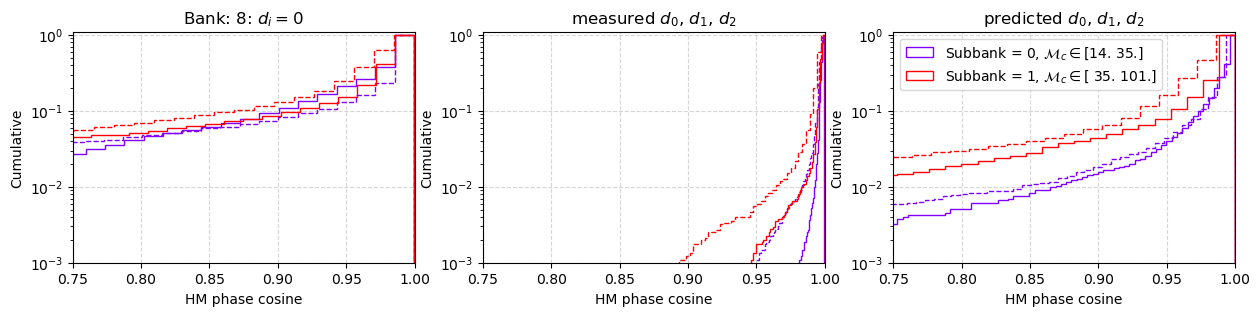

In [28]:
# Making cosine plots
# c_alphas were for 22 phases, d_alphas are similar coefficients but for (HM-22) phases

from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, len(bins)))
plt.figure(figsize=(15,3))

plt.subplot(131)
for isb in range(len(bins)):
    i=2*isb
    plt.hist(cos_exp_f0[i+0],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f0[i+1],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='dashed');
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.75,1)
plt.xlabel('HM phase cosine'); plt.ylabel('Cumulative')
plt.title(r'Bank: '+str(ib)+': $d_i = 0$');

plt.subplot(132)
for isb in range(len(bins)):
    i=2*isb
    plt.hist(cos_exp_f1[i+0],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f1[i+1],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='--');
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.75,1)
plt.xlabel('HM phase cosine'); plt.ylabel('Cumulative')
plt.title('measured $d_0$, $d_1$, $d_2$');

plt.subplot(133)
for isb in range(len(bins)):
    i=2*isb
    plt.hist(cos_exp_f2[i+0],bins=100,density=True,histtype='step',label='Subbank = '+str(isb)+', $\mathcal{M}_c\in$'+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f2[i+1],bins=100,density=True,histtype='step',cumulative=True,color=color[isb],ls='--');
    
plt.yscale('log')
plt.legend(loc=2) #loc=(1.05,0)
plt.ylim(0.001,1.1); plt.xlim(0.75,1)
plt.xlabel('HM phase cosine'); plt.ylabel('Cumulative')
plt.title('predicted $d_0$, $d_1$, $d_2$');

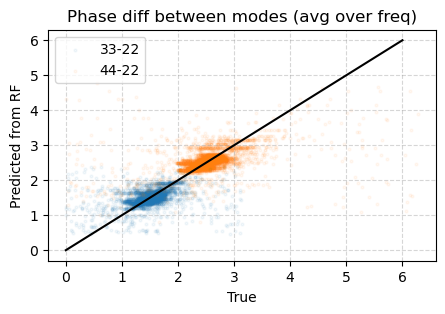

In [63]:
plt.scatter(constant[ind,0],ca_grid_pred[:,0],s=4,alpha=0.05,label='33-22')
plt.scatter(constant[ind,1],ca_grid_pred[:,1],s=4,alpha=0.05,label='44-22')
plt.plot(np.arange(0,7),np.arange(0,7),c='k')
plt.legend(); plt.xlabel('True'); plt.ylabel('Predicted from RF'); plt.title('Phase diff between modes (avg over freq)');

In [65]:
# Saving the SVDs and the random forest

# rg_rf = RandomForestRegressor(n_estimators=50, max_depth=60, random_state=2)
# for ib in range(nbanks):
#     ca_SubBanks, Vph_SubBanks, _ = SVD_HM_banks(ib)
#     dire = os.path.join(tbp.DIR,'BBH_'+str(ib))
    
#     for isb in range(SubBankSplits[ib]):
#         dire2 = os.path.join(dire,'bank_'+str(isb),'HM')
#         ####os.makedirs(dire2)
#         caHM  = ca_SubBanks[isb]; Vph = Vph_SubBanks[isb];
#         np.save(os.path.join(dire2,f'avg_phase_evolution_HM.npy'),Vph[:2])
#         np.save(os.path.join(dire2,f'svd_phase_basis_HM.npy'),Vph[2:])

#         ndims22=2
#         ca22 = np.load(os.path.join(os.path.dirname(dire2),'coeffs.npy'))[:,:ndims22]
#         rg_rf.fit(ca22, caHM) # Time intensive
#         joblib.dump(rg_rf, os.path.join(dire2,f'RandomForest_HM.pkl'), compress=3)

### SVD for amplitudes

In [ ]:
# Each bank is assigned to a reference amplitude, given by Af_kmeans_ii
# However, for banks with very mass BHs, amplitudes of waveforms can vary significantly within banks,
# we therefore calculate amplitudes as a function of calpha of 22 phase
# These calphas provide info on the mass ratio and chieff, which can then determine amplitudes

In [65]:
ib = 4 # id of bank to probe
ndims_HM = 2 # Dimensions of amp basis to include

ca_SubBanks=[]; Vph_SubBanks=[]
for ib in [ib]: #range(nbanks)
    bins=SubBank_Mchirp_bins[ib]
    _=[]; _2=[]
    for isb in range(len(bins)):
        mask=bank_ids==ib; mask*=subbank_ids==isb
        amps = amps_samples[:,0,:][mask]-Af_kmeans_22[ib]
        Up, sp, Vph = np.linalg.svd(amps, full_matrices=False)
        ca22 = (Up @ np.diag(sp))[:,:ndims_HM]; Vph22 = Vph[:ndims_HM]
        
        amps = amps_samples[:,1,:][mask]-Af_kmeans_33[ib]
        Up, sp, Vph = np.linalg.svd(amps, full_matrices=False)
        ca33 = (Up @ np.diag(sp))[:,:ndims_HM]; Vph33 = Vph[:ndims_HM]
        
        amps = amps_samples[:,2,:][mask]-Af_kmeans_44[ib]
        Up, sp, Vph = np.linalg.svd(amps, full_matrices=False)
        ca44 = (Up @ np.diag(sp))[:,:ndims_HM]; Vph44 = Vph[:ndims_HM]
        
        _.append(np.c_[ca22, ca33, ca44]); _2.append(np.array([Vph22, Vph33, Vph44]))

    ca_SubBanks.append(_); Vph_SubBanks.append(_2)

In [66]:
# Checking the cosines

rg_rf = RandomForestRegressor(n_estimators=60, max_depth=60, random_state=2) #J

bins=SubBank_Mchirp_bins[ib]
cos_exp_f0=[]; cos_exp_f1=[]; cos_exp_f2=[]
ca_SubBank = ca_SubBanks[0]; Vph_SubBank = Vph_SubBanks[0] # 0 corresponds to ib

# Loading 22 calphas
dire = os.path.join(tbp.DIR,'BBH_'+str(ib))

for isb in range(len(bins)):
    
    dire2 = os.path.join(dire,'bank_'+str(isb))
    caPh = np.load(os.path.join(dire2,'coeffs.npy'))
    mask=bank_ids==ib; mask*=subbank_ids==isb
    
    ca  = ca_SubBank[isb]
    Vph = Vph_SubBank[isb]
    
    amps_f= Af_kmeans_22[ib]
    cos_exp_f0.append(np.sum(amps_samples[:,0,:][mask] * amps_f * weights, axis=-1))
    amps = amps_samples[:,1,:][mask]
    amps_f= Af_kmeans_33[ib]
    cos_exp_f0.append(np.sum(amps_samples[:,1,:][mask] * amps_f * weights, axis=-1))
    amps = amps_samples[:,2,:][mask]
    amps_f= Af_kmeans_44[ib]
    cos_exp_f0.append(np.sum(amps_samples[:,2,:][mask] * amps_f * weights, axis=-1))
    
    ca_grid=np.rint(ca*8)/8. # Gridding
    amps_f= ca_grid[:,:2] @ Vph[0] + Af_kmeans_22[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f1.append(np.sum(amps_samples[:,0,:][mask] * amps_f * weights, axis=-1))
    amps_f= ca_grid[:,2:4] @ Vph[1] + Af_kmeans_33[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f1.append(np.sum(amps_samples[:,1,:][mask] * amps_f * weights, axis=-1))
    amps_f= ca_grid[:,4:6] @ Vph[2] + Af_kmeans_44[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f1.append(np.sum(amps_samples[:,2,:][mask] * amps_f * weights, axis=-1))
    
    if((ib==0 and isb==2) or (ib==0 and isb==3) or (ib==1 and isb==0) or (ib==2 and isb==0)): ndims=3
    else: ndims=2
    caPh_grid = caPh.copy(); caPh_grid = np.rint(caPh_grid*8)/8.; caPh_grid[:,ndims:]=0
    
    # Training a RF:
    ind=np.random.choice([0, 1], size=(len(ca),), p=[1./2, 1./2]).astype('bool');
    ca_grid = ca_grid[ind]; caPh_grid = caPh_grid[ind]
    rg_rf.fit(caPh[:, :ndims][~ind],ca[~ind])
    
    # or directly loading the RF:
    # rg_rf = pickle.load(open(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'RandomForest.pkl'), "rb"))
    
    ca_grid = rg_rf.predict(caPh_grid[:,:ndims])
    amps_f= ca_grid[:,:2] @ Vph[0] + Af_kmeans_22[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f2.append(np.sum(amps_samples[:,0,:][mask][ind] * amps_f * weights, axis=-1))
    
    amps_f= ca_grid[:,2:4] @ Vph[1] + Af_kmeans_33[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f2.append(np.sum(amps_samples[:,1,:][mask][ind] * amps_f * weights, axis=-1))
    
    amps_f= ca_grid[:,4:] @ Vph[2] + Af_kmeans_44[ib]
    amps_f = (amps_f.T/np.sqrt(np.sum(amps_f * amps_f * weights, axis=-1))).T
    cos_exp_f2.append(np.sum(amps_samples[:,2,:][mask][ind] * amps_f * weights, axis=-1))

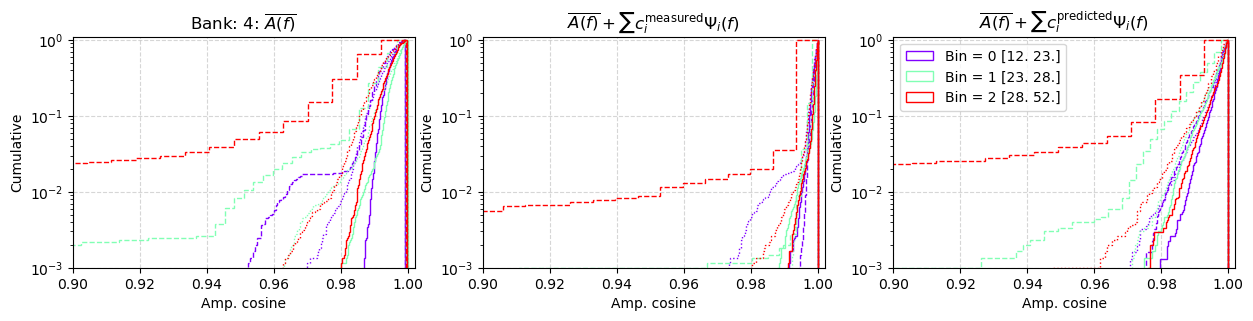

In [67]:
# Making cosine plots
# c_alphas were for 22 phases, d_alphas are similar coefficients but for (HM-22) phases

from matplotlib.pyplot import cm
color = cm.rainbow(np.linspace(0, 1, len(bins)))
plt.figure(figsize=(15,3))

plt.subplot(131)
for isb in range(len(bins)):
    ind=3*isb
    plt.hist(cos_exp_f0[ind+0],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f0[ind+1],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='dashed');
    plt.hist(cos_exp_f0[ind+2],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='dotted');
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.9,1.002)
plt.xlabel('Amp. cosine'); plt.ylabel('Cumulative')
plt.title(r'Bank: '+str(ib)+': $\overline{A(f)}$');

plt.subplot(132)
for isb in range(len(bins)):
    ind=3*isb
    plt.hist(cos_exp_f1[ind+0],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f1[ind+1],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='dashed');
    plt.hist(cos_exp_f1[ind+2],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb],ls='dotted');
    
plt.yscale('log')
plt.ylim(0.001,1.1); plt.xlim(0.9,1.002)
plt.xlabel('Amp. cosine'); plt.ylabel('Cumulative')
plt.title('$\overline{A(f)} + \sum c^\mathrm{measured}_i \Psi_i(f)$');

plt.subplot(133)
for isb in range(len(bins)):
    ind=3*isb
    plt.hist(cos_exp_f2[ind+0],bins=100,density=True,histtype='step',label='Bin = '+str(isb)+' '+ str(np.round(bins[isb])),cumulative=True,color=color[isb]);
    plt.hist(cos_exp_f2[ind+1],bins=100,density=True,histtype='step',cumulative=True,color=color[isb],ls='dashed');
    plt.hist(cos_exp_f2[ind+2],bins=100,density=True,histtype='step',cumulative=True,color=color[isb],ls='dotted');
    
plt.yscale('log')
plt.legend(loc=2) #loc=(1.05,0)
plt.ylim(0.001,1.1); plt.xlim(0.9,1.002)
plt.xlabel('Amp. cosine'); plt.ylabel('Cumulative')
plt.title('$\overline{A(f)} + \sum c^\mathrm{predicted}_i \Psi_i(f)$');

In [68]:
# Saving the SVD basis and the random forest

rg_rf = RandomForestRegressor(n_estimators=60, max_depth=60, random_state=2)
for ib in [ib]: #range(nbanks)
    ca_SubBank=ca_SubBanks[0]; Vph_SubBank=Vph_SubBanks[0]
    
    for isb in range(SubBankSplits[ib]):
        dire2 = os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb))
        # #os.makedirs(dire2)
        np.save(os.path.join(dire2,f'svd_amp_basis.npy'),Vph_SubBank[isb]*Aref)

        ndims22=2

        ca22 = np.load(os.path.join(dire2,'coeffs.npy'))[:,:ndims22]
        rg_rf.fit(ca22, ca_SubBank[isb]) # Time intensive
        joblib.dump(rg_rf, os.path.join(dire2,f'RandomForest_amps.pkl'), compress=3)

In [ ]:
# Files are only saved for select subbanks:
# BBH 4-all, BBH 5-all, BBH 6-all, BBH 7-all, BBH 8-all, BBH 9-0, BBH 15-0, BBH 16-0

## Extras

In [ ]:
# You could ignore these sections

### Index in bank.coeffs which gives minimum shift (which is used in conditioning the wf)

In [ ]:
# We will calculate the shifts corresponding to calpha waveforms, for calphas which are projections
# of phases of physical wfs used in the construction of banks
# Warning this takes a lot of time to run (20 min)

# List of sub-banks
subbanks = []
for ib in range(nbanks):
    for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
        subbanks.append([ib,isb]) 

# Prints the minimum shift and the index which gives it
def min_shift(ind):
    [ib,isb] = subbanks[ind]
    bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
    bank.set_waveform_conditioning(2**18, 1/2048)
    shifts_bank_min = 0
    for i in range(len(bank.coeffs)):
        h = bank.gen_wfs_fd_from_calpha(calpha=bank.coeffs[::sampling_factor][i], fs_out=bank.fs_fft, log=False)[0]
        wf_whitened_fd = h * bank.wt_filter_fd * np.sqrt(2 * bank.dt)
        _, shifts_bank, _ = bank.get_waveform_conditioning(bank.fftsize, bank.dt, wf_whitened_fd)
        if (shifts_bank_min > shifts_bank): shifts_bank_min = shifts_bank; index = i
    return([shifts_bank_min, index*sampling_factor])

with mp.Pool(20) as p:
        min_shifts = p.map(min_shift,np.arange(len(subbanks)))

In [199]:
# This will read the old metadata file and add another entry corresponding to 'min_shift_calpha_ind'

# for ind in range(len(subbanks)):
#     [ib,isb] = subbanks[ind]
#     with open(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'), 'r') as f:
#         metadata = json.load(f)
#         metadata['min_shift_calpha_ind']=min_shifts[ind][1]
#     with open(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'), 'w') as f:
#         json.dump(metadata, f, indent=2, cls=utils.NumpyEncoder)

### Physical regions for HM scores (modes_score_ratios_physical)

In [23]:
# Taken from 'Test effectualness' section in TemplateBank_HigherModes.ipynb
input_pars = np.load(os.path.join(tbp.wf_DIR,'pars_samples.npy'))
bank_ids = np.load(os.path.join(tbp.wf_DIR,'bank_ids.npy'))
SubBank_Mchirp_bins = np.load(os.path.join(tbp.wf_DIR,'SubBank_Mchirp_bins.npy'),allow_pickle=True)
SubBankSplits=[5,3,3,3,3,3,3,2,2,1,1,1,1,1,1,1,1]

In [34]:
subbanks = []
for ib in range(17):
    for isb in range(SubBankSplits[ib]):
        subbanks.append([ib,isb])
subbanks = np.array(subbanks)

In [38]:
def overlap(h1_dets, h2_dets,absolute=True):
    overlaps = np.sum(h1_dets * np.conj(h2_dets) * weights, axis=-1)
    if absolute: return abs(overlaps)
    else: return (overlaps)

def calculate_Z(par_dic, orthogonalize=True):
    h1 = np.zeros((3,len(f_amp)),dtype='complex128') 
    for i in range(3): 
        h1[i] = tg.compute_hplus_hcross(f_amp, par_dic, 'IMRPhenomXHM', [(2+i, 2+i)])[0]/Aref;
        h1[i] /= np.sqrt(overlap(h1[i],h1[i]))
        
    if orthogonalize:
        _ , CovMat= orthogonalize_wfs(wfs=h1, weights=weights)
    else:
        _ = h1.copy()
    href = tg.compute_hplus_hcross(f_amp, par_dic, 'IMRPhenomXHM', [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)])/Aref
    norm = overlap(href, href) # norm includes both h+ and hx
    href = href[0]/np.sqrt(norm[0])
    z22 = overlap(href,_[0])
    z33 = overlap(href,_[1])
    z44 = overlap(href,_[2])
    return([z22, z33, z44, np.sum(norm)])

# Taken from template bank generator
def orthogonalize_wfs(wfs, weights):
        
    full_CovMat = np.zeros((3,3),dtype = 'complex128')

    for (j,k) in np.array(np.triu_indices(3)).T:
        full_CovMat[j,k] = np.sum( weights* wfs[j]* np.conj(wfs[k]), axis=-1)

    full_CovMat[np.tril_indices(3)] = full_CovMat.T.conj()[np.tril_indices(3)]

    L = np.linalg.cholesky( np.linalg.inv(full_CovMat[::-1,::-1]) )[::-1,::-1]

    wfs = np.dot( L.conj().T, wfs)

    return(wfs, full_CovMat)

In [39]:
def ratios_modes(iota, p, orthogonalize=True):
    par_dic['iota'] = iota
    par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]
    _ = calculate_Z(par_dic, orthogonalize=orthogonalize)
    ratio33 = _[1]/_[0]
    ratio44 = _[2]/_[0]
    weights_samples = (_[3]**1.5 *1e65) * np.sin(iota) * (p[0]/p[1])**0.5
    # first term is the volume factor, second for jacobian of iota, third gives more weight to unequal mass ratio systems
    return [ratio33, ratio44, weights_samples]

In [40]:
incl_array = np.random.rand(2048)*np.pi/2

# Inclination distribution taken from Eq. (28) of Schutz et al 2011 (1102.5421)
P_incl = lambda i:  2*0.076*(1+6*np.cos(i)**2+np.cos(i)**4)**1.5 * np.sin(i)
# not used here, just provided in case one wants to compare

In [75]:
def generate_bank_ratios(ib,isb):
    _ = Mchrandom[bank_ids==ib]
    mask2 = _<=SubBank_Mchirp_bins[ib][isb][1]; mask2 *= _>SubBank_Mchirp_bins[ib][isb][0] 
    pars_bank = input_pars[bank_ids==ib][mask2]
    
    size=2048
    ind_random = np.random.choice(np.arange(len(pars_bank)), size=size, replace=False)
    mode_ratios = np.zeros((2,size,3))
    with mp.Pool(20) as p:
        # Sampling over inclinations
        # these samples are later used to remove triggers with low SNR for unphysical HM amplitude ratio
        mode_ratios[0] = np.array(np.abs(p.starmap(ratios_modes,
                           ((incl_array[i], pars_bank[ind_random[i]]) for i in np.arange(size)))))
        mode_ratios[0,:,2] /= np.sum(mode_ratios[0,:,2])
        
        # For generating samples which are input to the HM coherent score
        # inclination is fixed at edge-on and non-orthogonalized version of HM is used
        mode_ratios[1] = np.abs(p.starmap(ratios_modes,
                           ((np.pi/2, pars_bank[ind_random[i]], False) for i in np.arange(size))))
        mode_ratios[1,:,2] /= np.sum(mode_ratios[1,:,2])
    
    # Uncomment to save these samples into the template bank
    # dire = os.path.join(tbp.DIR, f'BBH_{ib}/bank_{isb}/HM/')
    # np.save(dire+f'HM_amp_ratio_samples.npy', mode_ratios)
    
    return(mode_ratios)

In [86]:
ratios = generate_bank_ratios(12,0)

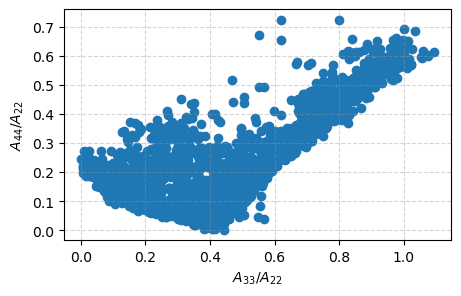

In [87]:
plt.scatter(ratios[1,:,0], ratios[1,:,1])
plt.xlabel('$A_{33}/A_{22}$'); plt.ylabel('$A_{44}/A_{22}$');

In [ ]:
# For running across all subbanks
for subbank in subbanks: generate_bank_ratios(subbank[0],subbank[1]);

# 2. using Template_bank_generator class

In [18]:
ib=8; # Bank number
isb=0 # Sub-bank number
fs_fft = np.fft.rfftfreq(2**18, 1/2048)

In [ ]:
bank = tg.TemplateBank.from_json(os.path.join(data_dir,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
bank.set_waveform_conditioning(2**18, 1/2048)

In [107]:
f_phase = bank.fs_basis
fmin = bank.fs_basis[0]; fmax = bank.fs_basis[-1];

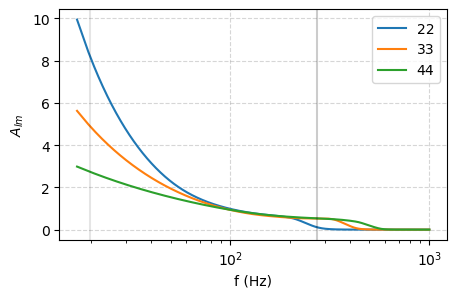

In [97]:
fig, ax = plt.subplots()
ax.semilogx(bank.amp[:, 0], bank.amp[:, 1], label='22')
ax.semilogx(bank.amp[:, 0], bank.amp[:, 2], label='33')
ax.semilogx(bank.amp[:, 0], bank.amp[:, 3], label='44')
plt.axvline(x=fmin,color = 'k',alpha=0.1); plt.axvline(x=fmax,color = 'k',alpha=0.2);
plt.legend()
plt.xlabel('f (Hz)'); plt.ylabel('$A_{lm}$');

In [98]:
ca_grid = bank.get_coeff_grid(delta_calpha=tbp.delta_calpha[f'BBH_{ib}'])
phases = bank.gen_phases_from_calpha(calpha=ca_grid[0], fs_out=fs_fft)

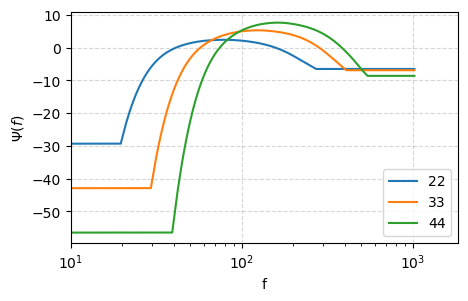

In [99]:
plt.semilogx(fs_fft, phases[0])
plt.semilogx(fs_fft, phases[1])
plt.semilogx(fs_fft, phases[2])
plt.legend(['22','33','44'])
plt.xlabel('f'); plt.ylabel('$\Psi(f)$')
plt.xlim(1e1);

In [17]:
wf = bank.gen_whitened_wfs_td(calpha=ca_grid[5])
wf = np.roll(wf,-10000,axis=-1)

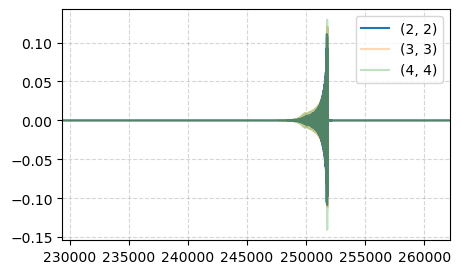

In [31]:
fig, ax = plt.subplots()
ax.plot(wf[0], label='(2, 2)')
ax.plot(wf[1], alpha=0.3, label='(3, 3)')
ax.plot(wf[2], alpha=0.3, label='(4, 4)')
ax.set_xlim((bank.fftsize - bank.support_whitened_wf, bank.fftsize))
ax.legend();

In [87]:
# For checking the number of templates in each subbank (can also use the function bank.ntemplates())

templates = []
for ib in range(17):
    _ = []
    for isb in range(tbp.nsubbanks['BBH_'+str(ib)]):
        bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
        _.append(len(bank.get_coeff_grid(delta_calpha = tbp.delta_calpha[f'BBH_{ib}'], fudge=tbp.fudge[f'BBH_{ib}'])))
    templates.append(_)
    
for ib in range(17):
    print(f'Bank {ib}: templates {templates[ib]}')
    
print(f'Total number of templates is {np.sum(np.concatenate(templates))}')

Bank 0: templates [10819, 1632, 762, 473, 327]
Bank 1: templates [972, 180, 104]
Bank 2: templates [438, 88, 63]
Bank 3: templates [2307, 677, 352]
Bank 4: templates [365, 81, 66]
Bank 5: templates [765, 301, 211]
Bank 6: templates [211, 92, 59]
Bank 7: templates [276, 160]
Bank 8: templates [109, 86]
Bank 9: templates [54]
Bank 10: templates [34]
Bank 11: templates [21]
Bank 12: templates [10]
Bank 13: templates [6]
Bank 14: templates [4]
Bank 15: templates [4]
Bank 16: templates [3]
Total number of templates is 22112


## 2.1. Triggering with the new template bank

In [ ]:
# For triggering on individual tgps files with the new template bank
# If you want to trigger in bulk over all the files on a HPC cluster, see run_Helios.py

In [23]:
import triggers_single_detector_HM as trig
import scipy.stats as stats

In [24]:
ib=8; # Bank number
isb=0 # Sub-bank number
detector = 'H1'; 
output_dir='/data/jayw/IAS/GW/Trash/Delete' # output triggers will be saved here

In [25]:
# Choosing a random tgps file (you can also choose a specific one)
fnames = os.listdir(f'/data/bzackay/GW/O3a/{detector}/')
fnames = np.random.choice(fnames, size=1, replace=False)
fnames = [f'/data/bzackay/GW/O3a/{detector}/' + str(fname) for fname in fnames]

In [27]:
fnames

['/data/bzackay/GW/O3a/H1/H-H1_GWOSC_O3a_4KHZ_R1-1253117952-4096.hdf5']

In [28]:
for fname in fnames:
    print('Running file:', fname)
    out_files = run_helios.filelist(fname=fname,output_dir=output_dir) # just to print names of output files (not running Helios)
    try: os.remove(out_files[3]); os.remove(out_files[4]); os.remove(out_files[5]) # remove the old output files with the same name
    except: pass
    left_fname, right_fname = utils.get_left_right_fnames(fname)
    trigObj = trig.TriggerList(fname = fname,
                 left_fname=left_fname,
                 right_fname=right_fname,
                 template_conf = f"/data/bzackay/GW/templates/O3_hm/Multibanks/BBH_{ib}/bank_{isb}/metadata.json", # path to template banks
                 fname_preprocessing = out_files[5],
                 trig_fname = out_files[3],
                 delta_calpha = tbp.delta_calpha[f'BBH_{ib}'])
    
    trigObj.gen_triggers(trig_fname=out_files[3])
    trigObj.to_json(out_files[4])

Running file: /data/bzackay/GW/O3a/H1/H-H1_GWOSC_O3a_4KHZ_R1-1253117952-4096.hdf5
--> setting support=min_trunc_len
Estimated waveform duration:  16
Estimated invalid seconds to the left: 49
Estimated invalid seconds to the right: 33
Length of data pulled in from left file: 49
Length of data pulled in from right file: 33
Computing glitch detector thresholds
Starting basic data processing
Looking for outliers in whitened strain data
Maximum strain = 418, Empirical threshold = 5.58, Applied Threshold = 41.8

0 66 0 0 0 True 0.5751953125
Looking for outliers in whitened strain data
Maximum strain = 9.21, Empirical threshold = 5.58, Applied Threshold = 11.4

Looking for sine-Gaussians around 60.0 Hz, bandwidth 10.0 Hz
Maximum score = 3.76, Empirical threshold = 4.97, Applied Threshold = 12.8

Looking for sine-Gaussians around 40 Hz, bandwidth 40 Hz
Maximum score = 3.48, Empirical threshold = 5.27, Applied Threshold = 14.4

Looking for sine-Gaussians around 120.0 Hz, bandwidth 40 Hz
Maximum

/data/jayw/IAS/GW/gw_detection_ias/data_operations.py:2331: RuntimeWarning: invalid value encountered in divide
  avg_seq = np.convolve(power_sequence * mask_times, filt, 'valid') / nsamp


Looking for excess power in 1.0 s, [70, 80] Hz
Maximum power = 36.2, Gaussian threshold = 36.8, Applied Threshold = 190

Looking for excess power in 1 s, [40, 60] Hz
Maximum power = 53.1, Gaussian threshold = 47.6, Applied Threshold = 300

Looking for excess power in 1 s, [25, 50] Hz
Maximum power = 76.4, Gaussian threshold = 52.1, Applied Threshold = 287

Looking for excess power in 0.5 s, [40, 60] Hz
Maximum power = 43.7, Gaussian threshold = 38.8, Applied Threshold = 303

Looking for excess power in 0.25 s, [140, 160] Hz
Maximum power = 50, Gaussian threshold = 33.2, Applied Threshold = 82.8

Looking for excess power in 1.0 s, [20, 50] Hz
Maximum power = 76.3, Gaussian threshold = 53.8, Applied Threshold = 285

Looking for excess power in 1.0 s, [100, 180] Hz
Maximum power = 201, Gaussian threshold = 87.9, Applied Threshold = 294

Not a single valid frequency channel available for dt = 0.05 s, f in [25, 70] Hz
Looking for excess power in 0.1 s, [25, 70] Hz
Maximum power = 105, Gauss

/data/jayw/Softwares/miniconda3/envs/gw/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/jayw/Softwares/miniconda3/envs/gw/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Used band eraser
Length of corrupted data (s) =  69.59619140625
Finished basic data processing
Basic data processing time: 135.96626806259155
PSD window size:  56060
Saving 634778 new candidates


In [29]:
# Loading the file output as a trigger object
trigObj = trig.TriggerList.from_json(os.path.join(output_dir,'H-H1_GWOSC_O3a_4KHZ_R1-1253117952-4096_config.json'))

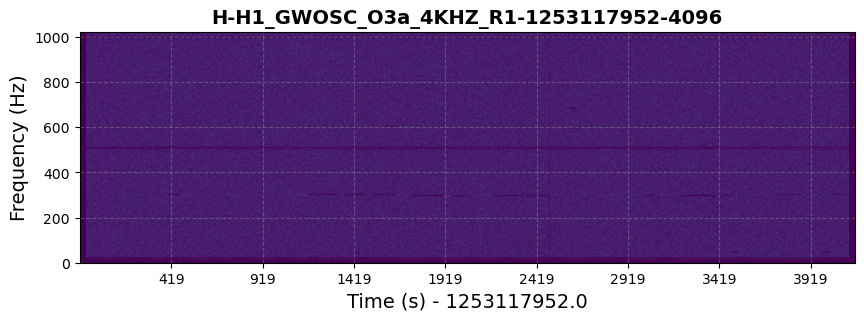

In [30]:
fig, ax = plt.subplots(figsize=(10,3))
trigObj.specgram(ax=ax);

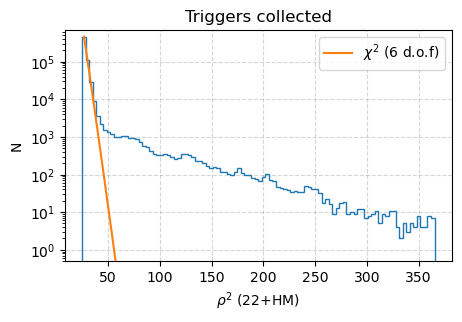

In [36]:
triglist = trigObj.processedclist
scores = triglist[:,1] # see trigger_single_detector_HM.py process_clist function for the different columns
val,bins,_ = plt.hist(scores,log=True, bins=100, histtype='step')
bincent = utils.bincent(bins)
plt.plot(bincent,stats.chi2.pdf(bincent,6)/stats.chi2.pdf(bincent[0],6)*val[0], label='$\chi^2$ (6 d.o.f)')
plt.legend(); plt.ylim(0.5,amax(val)*1.5);
plt.ylabel('N'); plt.xlabel(r'$\rho^2$ (22+HM)'); plt.title('Triggers collected');

In [37]:
# Collecting all the glitches with SNRsq>50 and maximizing them over a 0.1s interval
mask = scores>50
loud_list = utils.splitarray(triglist[mask],triglist[mask,0],interval=0.1)
glitchlist = np.array([x[np.argmax(x[:,1])] for x in loud_list])
len(loud_list)

6

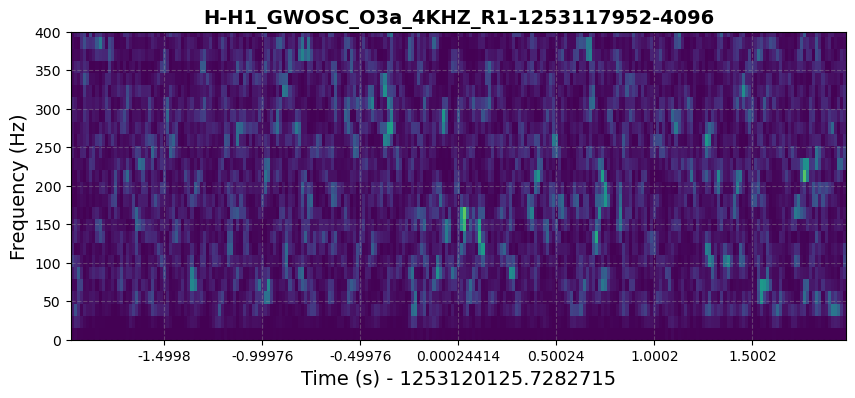

In [52]:
# Looking at a particular candidate with index 'ind'
ind=4
plot_time = 2
tglitch = glitchlist[ind,0]

fig, ax = plt.subplots(figsize=(10,4))
trigObj.specgram(t0=tglitch, tmin = -plot_time, tmax=plot_time, nfft=128, noverlap=96, ax=ax)
ax.set_ylim(top=400);

/tmp/ipykernel_19806/1150602796.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


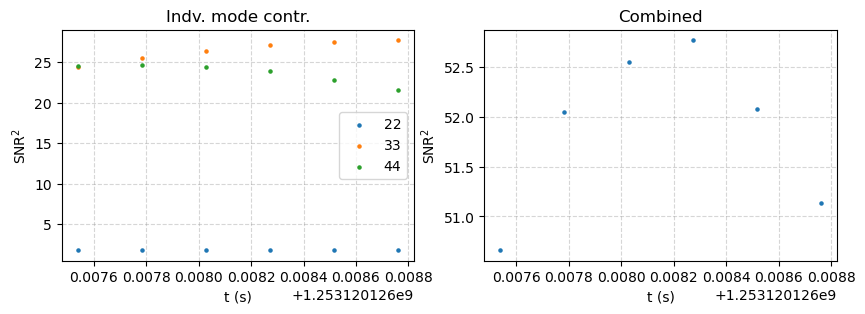

In [53]:
# Looking at the SNRsq contribution from each mode
plt.figure(figsize=(10,3))
plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
zsq_list = np.c_[loud_list[ind][:,7]**2+loud_list[ind][:,8]**2,
                 loud_list[ind][:,9]**2+loud_list[ind][:,10]**2,
                 loud_list[ind][:,11]**2+loud_list[ind][:,12]**2]

plt.subplot(121)
plt.scatter(loud_list[ind][:,0],zsq_list[:,0], s=5, label='22')
plt.scatter(loud_list[ind][:,0],zsq_list[:,1],color='C1', s=5, label='33')
plt.scatter(loud_list[ind][:,0],zsq_list[:,2],color='C2', s=5, label='44')
plt.legend(); plt.title('Indv. mode contr.')
plt.xlabel('t (s)'); plt.ylabel('SNR$^2$')

plt.subplot(122)
plt.scatter(loud_list[ind][:,0],loud_list[ind][:,1], s=5)
plt.xlabel('t (s)'); plt.ylabel('SNR$^2$'); plt.title('Combined');

# 3. Test effectualness

In [ ]:
# We calculate the effectualness for a particular sub-bank in this section

In [5]:
# Creating samples of input parameters with appropriate priors
# Load using the following or uncomment the code in the next cell:

pars_test = np.load(os.path.join(tbp.wf_DIR,'Testing_effectualness','pars_test.npy')) # similar to the input_pars array earlier
bank_ids_test = np.load(os.path.join(tbp.wf_DIR,'Testing_effectualness','bank_ids_test.npy')) # similar to the bank_ids array earlier

# Deriving Mchirp_test
_=np.exp(np.log(pars_test[:,1]/pars_test[:,0]))
_=_/(1+_)**2
Mchirp_test= (pars_test[:,0] + pars_test[:,1])*_**(3/5)

# Chirp mass bins of subbanks
SubBank_Mchirp_bins = np.load(os.path.join(tbp.wf_DIR,'SubBank_Mchirp_bins.npy'),allow_pickle=True)

# Other coordinates, in case they're needed
Mrandom = pars_test[:,0] + pars_test[:,1]
lnqrandom = np.log(pars_test[:,1]/pars_test[:,0])
[chieffrandom , cumchidiffrandom] = inverse_transform(pars_test[:,:4].T)

In [ ]:
# Use this cell only if you want to create a different bank_ids_test than already loaded above
# This cell determines the banks of the test wfs using same code as the 
# earlier section: 'Generate input waveforms & split banks by amplitude'.

# with mp.Pool(23) as p:
#         amps_samples = np.abs(p.starmap(amps_HM,
#                            ((f_amp, pars, False) for pars in pars_test)))

# amps_samples /= Aref
# _ = np.sum(weights*amps_samples**2,axis=-1)**0.5
# for i in range(len(amps_samples)):
#     amps_samples[i] = (amps_samples[i].T/_[i]).T

# bank_ids_test = kmeans.predict(amps_samples)
# bank_ids_test = np.asarray([np.where(order == b)[0][0] for b in bank_ids_test])

In [6]:
# Creating an samples of inclination corresponding to 22 brightness,
# inclination distribution is taken from https://arxiv.org/abs/1102.5421

InclArr=np.zeros(30000); j=0
while (j<30000):
    c=np.random.rand(); _=((1+6*c**2+c**4)**1.5)/(8**1.5)
    if(_ >np.random.rand()): 
        InclArr[j]=c;
        j+=1;

InclArr = np.arccos(InclArr)

In [7]:
# Reloading the sub-bank, if needed
# reload(tg)

ib=12; # Bank number
isb=0 # Sub-bank number
delta_calpha = tbp.delta_calpha[f'BBH_{ib}']

bank = tg.TemplateBank.from_json(os.path.join(tbp.DIR,'BBH_'+str(ib),'bank_'+str(isb),'metadata.json'))
bank.set_waveform_conditioning(2**18, 1/2048)

/data/jayw/Softwares/miniconda3/envs/lalsuite-dev/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/data/jayw/Softwares/miniconda3/envs/lalsuite-dev/lib/python3.10/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
# Finding the pars_test corresponding to the particular sub-bank 

_ = Mchirp_test[bank_ids_test==ib]
mask2 = _<=SubBank_Mchirp_bins[ib][isb][1]; mask2 *= _>SubBank_Mchirp_bins[ib][isb][0] 
pars_test_bank = pars_test[bank_ids_test==ib][mask2]

In [12]:
# Splitting the wfs into chunks to use less memory
nwfs_chunk = 2 # number of wfs in a chunk

def calc_faithfulness(ichunk, compare_with_22only=True):
    '''
    :param ichunk: Index of the wf chunk
    :param compare_with_22only: Boolean flag whether to compare the effectualness with a 22-only bank
    '''
    # First making test waveforms (lwfs = log of wfs)
    fs = bank.fs_unwrap
    lwfs = np.zeros((nwfs_chunk,len(bank.fs_fft)),dtype='complex128'); # Test wfs: 22 + HM
    lwfs22 = np.zeros((nwfs_chunk,len(fs)),dtype='complex128') # Test wfs: 22
    mask = bank.fs_fft>15
    lwfs[:,~mask] = -np.inf;
    for i in range(nwfs_chunk):
        p = pars_test_bank[ichunk*nwfs_chunk+i]
        par_dic['m1'] = p[0]; par_dic['m2'] = p[1]; par_dic['s1z'] = p[2]; par_dic['s2z'] = p[3]; 
        par_dic['iota'] = InclArr[ichunk*nwfs_chunk+i]
        h = tg.compute_hplus_hcross(fs, par_dic, 'IMRPhenomXAS', [(2, 2)])[0]
        lwfs22[i] = np.log(np.abs(h)) + 1j * np.unwrap(np.angle(h))

        h = tg.compute_hplus_hcross(bank.fs_fft[mask], par_dic, 'IMRPhenomXHM', [(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)])[0]
        lwfs[i,mask] = np.log(np.abs(h)) + 1j * np.unwrap(np.angle(h))
    
    lwfs22 = tg.upsample_lwfs(lwfs22, fs, bank.fs_fft)
    
    # Calculating effectualness of the wfs
    if compare_with_22only:
        return (# Test wfs: 22, Bank: 22
                np.c_[bank.test_faithfulness(wfs_fd=lwfs22, delta_calpha=delta_calpha, HM=False,do_optimization=True)[:,1],
                # Test wfs: 22+HM, Bank: 22
                bank.test_faithfulness(wfs_fd=lwfs, delta_calpha=delta_calpha, HM=False,do_optimization=True)[:,1],
                # Test wfs: 22+HM, Bank: 22+HM
                bank.test_faithfulness(wfs_fd=lwfs, delta_calpha=delta_calpha, wfs_22_fd=lwfs22, HM=True,do_optimization=True)[:,1]])
    
    else:
        # Test wfs: 22+HM, Bank: 22+HM
        return (bank.test_faithfulness(wfs_fd=lwfs, delta_calpha=delta_calpha, wfs_22_fd=lwfs22, HM=True,do_optimization=True)[:,1])

In [17]:
nwfs = 100
p = mp.Pool(20)
effectualness = p.starmap(calc_faithfulness, ((i, True) for i in np.arange(nwfs//2)))
p.close(); p.join()
effectualness = np.array(effectualness).reshape(-1,3)
# effectualness = np.ndarray.flatten(np.array(effectualness))

/data/jayw/IAS/GW/gw_detection_ias/template_bank_generator_HM.py:225: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/data/jayw/IAS/GW/gw_detection_ias/template_bank_generator_HM.py:225: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/data/jayw/IAS/GW/gw_detection_ias/template_bank_generator_HM.py:225: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/data/jayw/IAS/GW/gw_detection_ias/template_bank_generator_HM.py:225: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/data/jayw/IAS/GW/gw_detection_ias/template_bank_generator_HM.py:225: RuntimeWarning: divide by zero encountered in log
  np.log(np.interp(fs_out, fs_in, amp_arr, left=0., right=0.))
/data/jayw/IAS/GW/gw_detection_ias/template_bank_generator_HM.py:225: RuntimeWarning:

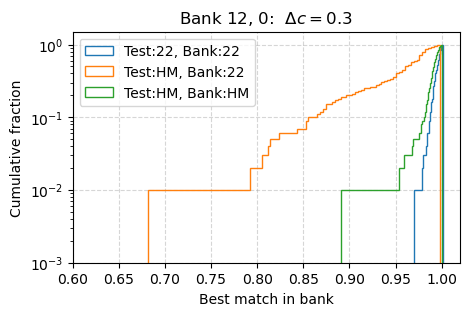

In [11]:
plt.hist(effectualness[:,0],bins=100,histtype='step',density=True, cumulative=True,label='Test:22, Bank:22')
plt.hist(effectualness[:,1],bins=100,histtype='step',density=True, cumulative=True, label='Test:HM, Bank:22')
plt.hist(effectualness[:,2],bins=100,histtype='step',density=True, cumulative=True, label='Test:HM, Bank:HM')
plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.yscale('log'); plt.xlabel('Best match in bank'); plt.ylabel('Cumulative fraction'); plt.legend(loc=2)
plt.xlim(left=0.6,right=1.02); plt.ylim(1e-3,1.5)
plt.title(f'Bank {ib}, {isb}:  $\Delta c=${delta_calpha}');

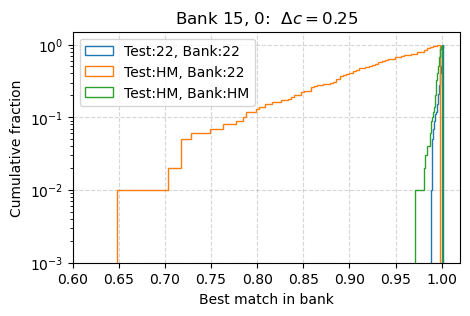

In [34]:
plt.hist(effectualness[:,0],bins=100,histtype='step',density=True, cumulative=True,label='Test:22, Bank:22')
plt.hist(effectualness[:,1],bins=100,histtype='step',density=True, cumulative=True, label='Test:HM, Bank:22')
plt.hist(effectualness[:,2],bins=100,histtype='step',density=True, cumulative=True, label='Test:HM, Bank:HM')
plt.grid(visible=True, which='major', color='#999999', linestyle='--',alpha=0.4)
plt.yscale('log'); plt.xlabel('Best match in bank'); plt.ylabel('Cumulative fraction'); plt.legend(loc=2)
plt.xlim(left=0.6,right=1.02); plt.ylim(1e-3,1.5)
plt.title(f'Bank {ib}, {isb}:  $\Delta c=${delta_calpha}');

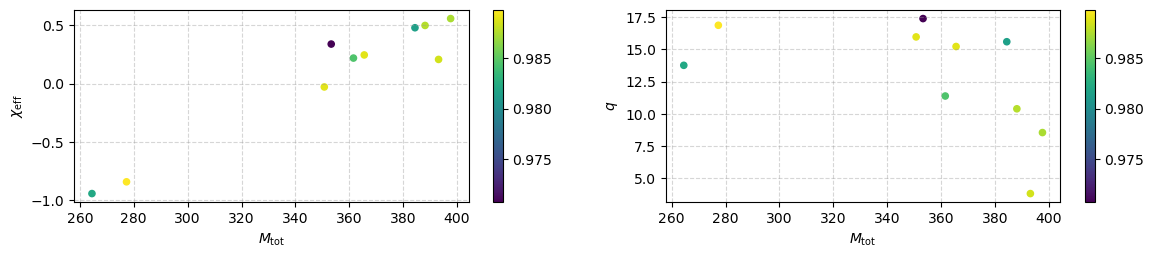

In [35]:
# Extra code: In case you want to probe where the worst cosine is
mask = effectualness[:,2]<.99
plt.figure(figsize=(14,2.5))
plt.subplot(121)
plt.scatter(Mrandom[bank_ids_test==ib][mask2][:nwfs][mask],chieffrandom[bank_ids_test==ib][mask2][:nwfs][mask],
            c=effectualness[:,2][mask],s=20,cmap='viridis'); plt.colorbar()
plt.xlabel('$M_\mathrm{tot}$'); plt.ylabel('$\chi_\mathrm{eff}$')
plt.subplot(122)
plt.scatter(Mrandom[bank_ids_test==ib][mask2][:nwfs][mask],1/np.exp(lnqrandom[bank_ids_test==ib][mask2][:nwfs][mask]),
            c=effectualness[:,2][mask],s=20,cmap='viridis'); plt.colorbar()
plt.xlabel('$M_\mathrm{tot}$'); plt.ylabel('$q$');